# Exploring deep sea acoustic events
## Whale song detector scan results

### Feb 2020 PDSG Applied Data Science Meetup series<br>John Burt

### Session details

For February’s four session meetup series we’ll be working with long term hydrophone recordings from University of Hawaii's Aloha Cabled Observatory (ACO - http://aco-ssds.soest.hawaii.edu), located at a depth of 4728m off Oahu. The recordings span a year and contain many acoustic events: wave movements, the sound of rain, ship noise, possible bomb noises, geologic activity and whale calls and songs. There is a wide range of project topics to explore: identifying and counting acoustic events such as whale calls, measuring daily or seasonal noise trends, measuring wave hydrodynamics, etc.

### This notebook:

Analyze the results of my CNN classifier's detection scan of the "every_other_hour" recording. This recording spans all of 2015, with 5 minutes of audio sampled every other hour. The detection script saves the audio for any frames the model classifies as having whale song to a detections folder for later review. I then examined the results after manually scanning every detection and entering a comment if the clip does not contain whale song.

In [125]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np

import librosa
import librosa.display


In [126]:
from IPython.display import HTML
# from IPython.display import Image
# Image("eyeexam.jpg")

HTML('''<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide()
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Code"></form>''')

### Initial results of detection clip scans

- The classifier detected 11593 possible whale song audio segments.


- I used SyrinxPC to scan the detection clips. I wrote this Windows software years ago and it is still the fastest way to scan a lot of audio files quickly. The procedure is simple: use a key command to advance through a spectrograph view of each detection clip and log a comment every time no whale could be seen or heard in the clip.


- The result was 1043 false detections (9%).


- Most of the false detections were from brief loud sounds - bumps, pops and clicks, ship noise, unidentified squeals and whines, hydrophone or cable issues and Minke whale calls.


- Looking at the text log file I created, I discovered that 237 of the logs had invalid date/time info, so I don't know when they occurred. The rest did have date/time info and I dropped them from the clip data for subsequent analysis.


- According to my log notes, song stopped after 09-20, and resumed after 11-05. I dropped any detection clips between these dates. Note: I didn't log every clip between these dates.


In [127]:
import os
import fnmatch
from datetime import datetime,timedelta  

def read_clipnames(srcdir):
    """Walk through base folder and collect paths for all sound files.
        parse date and time info, sort, and return as a dataframe"""
    
    clipexts=['*.wav']
    datefmt='%Y-%m-%d--%H'
#     2015-01-01--04_056

    # search through source folder for sound files
    # save clip path and date (parsed from filename)
    clippath = []
    clipdate = []
    clipname = []
    for ext in clipexts:
        for root, dirnames, filenames in os.walk(srcdir):
            for filename in fnmatch.filter(filenames, ext):
                clipname.append(filename)
                clippath.append(os.path.join(root, filename).replace('\\','/'))
                dateinfo = filename.split('.')[0].split('_')
                clipdate.append(datetime.strptime(dateinfo[0], datefmt) + 
                                timedelta(seconds=int(dateinfo[1])))
                
    # get sort index
    idx = np.argsort(clipdate)
    # retun sorted dataframe
    return pd.DataFrame({'date': np.array(clipdate)[idx], 
                       'path':  np.array(clippath)[idx],
                       'name': np.array(clipname)[idx]} )   

clipdf = read_clipnames('./data/model/detections/')

logdfnotime = pd.read_csv('./data/model/detection_log_notwhale_bad_dates.csv')
logdftime = pd.read_csv('./data/model/detection_log_notwhale_clipfile_names.csv')

print('Total detections =',clipdf.shape[0])
print('False detections =',logdftime.shape[0]+logdfnotime.shape[0])
print('  False detection logs w/ time info:', logdftime.shape[0])
print('  False detection logs w/out time info:', logdfnotime.shape[0])


Total detections = 11593
False detections = 1043
  False detection logs w/ time info: 806
  False detection logs w/out time info: 237


In [128]:
numclips = clipdf.shape[0]

# drop detections during period w/ no whale song
clipdf = clipdf[(clipdf['date']<datetime(year=2015,month=9,day=20)) |
                (clipdf['date']>datetime(year=2015,month=11,day=5)) ]

# drop all clips logged as not whale song
clipdf = clipdf[~clipdf['name'].isin(logdftime['clipname'])]

print('Total dropped false detections = ', numclips - clipdf.shape[0])

Total dropped false detections =  1158


## What time of year are whales singing?

>North Pacific Humpback Whales (Kohola) arrive in Hawaii after their journey from Alaska sometime from November to May, with most sightings January to March, making February the peak time. 

>From [skylinehawaii.com](https://www.skylinehawaii.com/blog/hawaiis-humpback-whales-migration)

### My results:

- According to the detection data, whales were singing from December - May, with a peak in March. 


- There's a dip in singing in February, or perhaps a mini-peak in January?

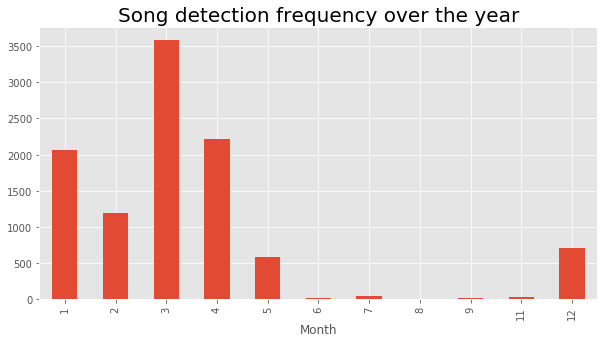

In [129]:
plt.figure(figsize=[10,5])
clipdf['date'].groupby(clipdf['date'].dt.month).count().plot(kind="bar")
plt.title('Song detection frequency over the year', fontsize=20)
plt.xlabel('Month');

## Looking more closely at January - March

It appears there isn't a smooth ramp up of singing, but instead there are multiple bouts of singing, with periods of very little song. It's possible that this represents a pattern of individual whales moving into and out of range of the hydrophone. Also, there might be weather events, such as storms that shut down singing. It would be interesting to look at storm data near Oahu during this time. 

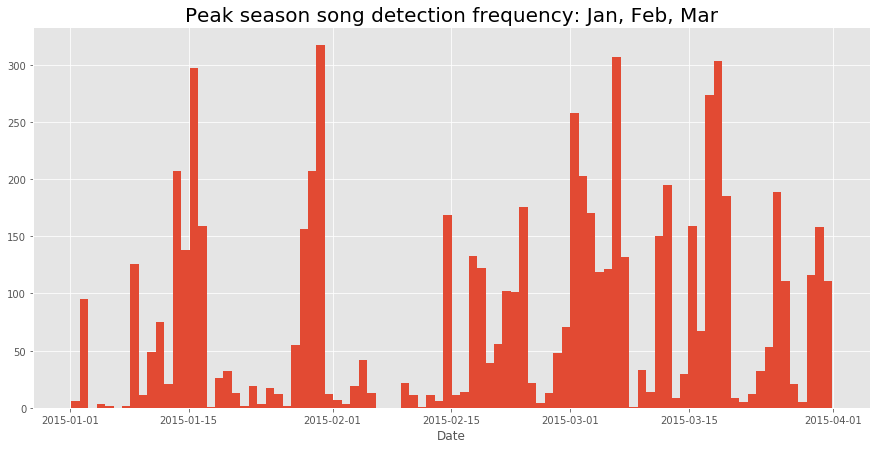

In [130]:
clipdate = clipdf['date'][clipdf['date']<datetime(year=2015, month=4, day=1)]

plt.figure(figsize=[15,7])
clipdate.hist(bins=90)
plt.title('Peak season song detection frequency: Jan, Feb, Mar', fontsize=20)
plt.xlabel('Date');


## Diurnal song patterns: when do whales sing?

>There are also indications of a diurnal pattern in sound pressure levels of whale song, whereby levels were significantly louder at night during the breeding season in Hawaii. Sound levels increased during sunset and only decreased at sunrise. It has been suggested that this pattern may reflect song being sexual advertisement as the main male mating strategy at night, while vision may be key to the formation of competitive groups during the day. There are several other alternative explanations. For example, many animals rely on sound for communication at night, and the humpbacks may simply be compensating for the increase in ambient noise. An-other possibility is that the whales are taking advantage of, or compensating for diurnal changes in oceanographic features, as discussed by Au et al.

>From: [Parsons et al "The Nature of Humpback Whale (Megaptera novaeangliae) Song" Journal of Marine Animals and Their Ecology (2008)](http://oers.ca/journal/journal1/Volume1/Issue1_6parsons2008.pdf)

### My results:

- The detection data supports the quote above: whales sing more, or more loudly at night (louder song travels farther and is more detectable).

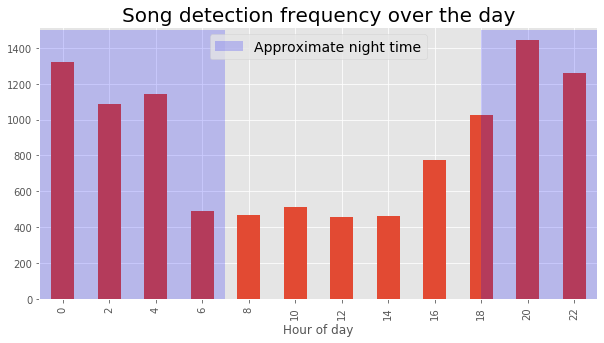

In [131]:
from matplotlib.patches import Rectangle

plt.figure(figsize=[10,5])
clipdf['date'].groupby(clipdf['date'].dt.hour).count().plot(kind="bar", label='')
plt.title('Song detection frequency over the day', fontsize=20)
plt.gca().add_patch(Rectangle((-.5, 0), 4, 1500, facecolor='blue', alpha=0.2))
plt.gca().add_patch(Rectangle((9, 0), 3, 1500, facecolor='blue', alpha=0.2, label='Approximate night time'))
plt.xlabel('Hour of day');
plt.legend(fontsize=14, loc='upper center');
